In [23]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm

In [24]:
# Function to extract epoch from the first few rows of the CSV file
def extract_epoch_from_header(file):
    # Read the first few lines to find the epoch (assuming it's in a comment or a header)
    with open(file, 'r') as f:
        skiprow = f.readline()
        skiprow = skiprow.strip().split()[0]
        for line in f:
            if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
                # Extract the epoch date (this assumes the date is the second item in the line)
                epoch = line.strip().split()[1]
                return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
    return None  # Return None if no epoch is found

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    nskiprows,epoch = extract_epoch_from_header(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['starttime'], unit='D') + pd.Timestamp(epoch)
   
    # Return the adjusted DataFrame
    return df

In [25]:
#set a working directory till NMVOC folder
working_dir = "C:\\Year1\\"
# Find all CSV files (change the path if nedeed)
prop_files = glob.glob(working_dir+"NMVOC\EBAS_propane\\*.nas") 
print(prop_files)

# this function reads apropadjust times for all CSV files
dfs = []
for file in prop_files:
    df = load_and_adjust_time(file)
    dfs.append(df)

# concatenates all DataFrames (based on time)
prop_df = pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
print(prop_df)

<>:4: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_14008\1492968850.py:4: SyntaxWarning: invalid escape sequence '\E'
  prop_files = glob.glob(working_dir+"NMVOC\EBAS_propane\\*.nas")


['C:\\Year1\\NMVOC\\EBAS_propane\\IT0009R.20110102223100.20160415000000.online_gc.propane.air.1y.2h.IT10L_GC-MS_6890-5975c_UNITY2-AIRSERVER2.IT10L_GPROSIM12_SETUPX1200.lev2.nas', 'C:\\Year1\\NMVOC\\EBAS_propane\\IT0009R.20120101152600.20160415000000.online_gc.propane.air.1y.2h.IT10L_GC-MS_6890-5975c_UNITY2-AIRSERVER2.IT10L_GPROSIM12_SETUPX1200.lev2.nas', 'C:\\Year1\\NMVOC\\EBAS_propane\\IT0009R.20130101000000.20160718000000.online_gc.propane.air.1y.2h.IT10L_GC-MS_6890-5975c_UNITY2-AIRSERVER2.IT10L_GPROSIM12_SETUPX1200.lev2.nas', 'C:\\Year1\\NMVOC\\EBAS_propane\\IT0009R.20140101002700.20160718000000.online_gc.propane.air.1y.2h.IT10L_GC-MS_6890-5975c_UNITY2-AIRSERVER2.IT10L_GPROSIM12_SETUPX1200.lev2.nas', 'C:\\Year1\\NMVOC\\EBAS_propane\\IT0009R.20150101004100.20170327080000.online_gc.propane.air.1y.2h.IT10L_GC-MS_6850-5975c_UNITY2-AIRSERVER2.IT10L_GPro22sim+setup1200.lev2.nas', 'C:\\Year1\\NMVOC\\EBAS_propane\\IT0009R.20160101004500.20180529080000.online_gc.propane.air.1y.2h.IT10L_GC-MS

In [26]:
df=prop_df
#remove lines depending on flags
df = df[df.flag != 0.999]
df = df[df.flag != 0.899]
df = df[df.flag != 0.456]
df = df[df.flag != 0.260]
df = df[df.flag != 0.259]
df = df[df.flag != 0.256]
df = df[df.C3H8 != 99999.99]

df.index = df["starttime_dt"]
#remove useless columns
df = df.drop(columns=["flag"])
df = df.drop(columns=["starttime"])
df = df.drop(columns=["endtime"])
df = df.drop(columns=["C3H8.1"])
df = df.drop(columns=["C3H8.2"])
df

,C3H8,starttime_dt
starttime_dt,,
2011-01-05 00:16:00.028800,709.74,2011-01-05 00:16:00.028800
2011-01-05 02:16:00.000000,785.50,2011-01-05 02:16:00.000000
2011-01-05 04:15:59.971200,726.28,2011-01-05 04:15:59.971200
2011-01-05 06:16:00.028800,947.38,2011-01-05 06:16:00.028800
2011-01-05 08:16:00.000000,743.31,2011-01-05 08:16:00.000000
...,...,...
2023-12-31 01:58:00.038400,76.56,2023-12-31 01:58:00.038400
2023-12-31 03:58:00.009600,118.15,2023-12-31 03:58:00.009600
2023-12-31 04:58:00.038400,106.64,2023-12-31 04:58:00.038400


In [27]:
# helper columns with  hour, month, year
df['hour'] = df['starttime_dt'].dt.hour
df['month'] = df['starttime_dt'].dt.month
df['year'] = df['starttime_dt'].dt.year
df['date'] = df['starttime_dt'].dt.date
df['day'] = df['starttime_dt'].dt.dayofyear

In [28]:
#loop for rounding to the hours
df["starttime_dt"] = [i.round("H") for i in df["starttime_dt"]]
#loop for rounding to the hours
df["datetime"]=df["starttime_dt"]
df = df.drop(columns=["starttime_dt"])
prop_df=df

C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_14008\4244259187.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["starttime_dt"] = [i.round("H") for i in df["starttime_dt"]]


In [29]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])



In [30]:
# Path to the text file
file_path1 =  r"C:\\YEAR1\\NMVOC\\CO_CH4\\ch4_cmn_surface-insitu_443_allvalid.txt"
file_path2 =  r"C:\\YEAR1\\NMVOC\\CO_CH4\\ICOS_ATC_L2_L2-2024.1_CMN_8.0_CTS.CH4"

In [31]:
#CH4 dataset between 2018 and 2024
ch4_24 = pd.read_csv(file_path2, sep=";",skiprows=44)
ch4_24 ['datetime'] = pd.to_datetime(ch4_24[['Year', 'Month', 'Day', 'Hour']])
ch4_24 = ch4_24[ch4_24['Flag'] != "N"]  # Filter rows where 'QCflag:comment' equals N
ch4_24 = ch4_24[ch4_24['Flag']!= "K"] 
ch4_24 = ch4_24[ch4_24['ch4']!= -9] 
ch4_24 = ch4_24.drop(columns=["Flag"]) 
ch4_24 = ch4_24.drop(columns=["Site"]) 
ch4_24 = ch4_24.drop(columns=["SamplingHeight"]) 
ch4_24 = ch4_24.drop(columns=["DecimalDate"]) 
ch4_24 = ch4_24.drop(columns=["NbPoints"]) 
ch4_24 = ch4_24.drop(columns=["InstrumentId"])
ch4_24 = ch4_24.drop(columns=["QualityId"])                            
ch4_24 = ch4_24.drop(columns=["LTR"])     
ch4_24 = ch4_24.drop(columns=["CMR"])                              
ch4_24 = ch4_24.drop(columns=["STTB"])    
ch4_24 = ch4_24.drop(columns=["QcBias"])  
ch4_24 = ch4_24.drop(columns=["QcBiasUncertainty"])                              
ch4_24 = ch4_24.drop(columns=["ch4-WithoutSpikes"]) 
ch4_24 = ch4_24.drop(columns=["Stdev-WithoutSpikes"]) 
ch4_24 = ch4_24.drop(columns=["NbPoints-WithoutSpikes"]) 
ch4_24 = ch4_24.drop(columns=["Stdev"]) 
ch4_24 = ch4_24.drop(columns=["Minute"]) 
ch4_24.rename(columns={"Year": "year", "Month": "month","Day":"day","Hour":"hour"},inplace=True)
ch4_24


,year,month,day,hour,ch4,datetime
168,2018,5,10,0,1944.79,2018-05-10 00:00:00
169,2018,5,10,1,1939.22,2018-05-10 01:00:00
170,2018,5,10,2,1931.26,2018-05-10 02:00:00
171,2018,5,10,3,1928.82,2018-05-10 03:00:00
172,2018,5,10,4,1932.80,2018-05-10 04:00:00
...,...,...,...,...,...,...
50265,2024,3,31,19,1994.03,2024-03-31 19:00:00
50266,2024,3,31,20,1992.84,2024-03-31 20:00:00
50267,2024,3,31,21,1990.84,2024-03-31 21:00:00
50268,2024,3,31,22,1990.17,2024-03-31 22:00:00


In [32]:
#CH4 dataset till 2017
ch4_17 = pd.read_csv(file_path1,sep=" ",skiprows=189)
ch4_17['datetime'] = pd.to_datetime(ch4_17[['year', 'month', 'day', 'hour']])
ch4_17 = ch4_17[ch4_17['qc_flag'] != 3]  # Filter rows where 'QCflag:comment' equals 3
ch4_17 = ch4_17[ch4_17['qc_flag']!= -999.999] 
ch4_17 = ch4_17[ch4_17['qc_flag']!= -9] 
ch4_17 = ch4_17[ch4_17['year']!= 2008] 
ch4_17 = ch4_17[ch4_17['year']!= 2009] 
ch4_17 = ch4_17[ch4_17['year']!= 2010] 
ch4_17 = ch4_17.drop(columns=["nvalue"]) 
#ch4_17 = ch4_17.drop(columns=["value_unc"]) 
ch4_17 = ch4_17.drop(columns=["second"])
ch4_17 = ch4_17.drop(columns=["year"])
ch4_17 = ch4_17.drop(columns=["month"])
ch4_17 = ch4_17.drop(columns=["day"])
ch4_17 = ch4_17.drop(columns=["hour"])
ch4_17 = ch4_17.drop(columns=["minute"])
#ch4_17 = ch4_17.drop(columns=["second"])
ch4_17 = ch4_17.drop(columns=["longitude"])
ch4_17 = ch4_17.drop(columns=["altitude"])
ch4_17 = ch4_17.drop(columns=["obspack_id"])
ch4_17 = ch4_17.drop(columns=["latitude"])
ch4_17 = ch4_17.drop(columns=["intake_height"])
ch4_17 = ch4_17.drop(columns=["obspack_num"])
ch4_17 = ch4_17.drop(columns=["unique_sample_location_num"])
ch4_17 = ch4_17.drop(columns=["qc_flag"])
ch4_17 = ch4_17.drop(columns=["datetimeISO"])
ch4_17 = ch4_17.drop(columns=["time"])
ch4_17 = ch4_17.drop(columns=["time_decimal"])
ch4_17 = ch4_17.drop(columns=["value_std_dev"])
ch4_17 = ch4_17.drop(columns=["icos_datalevel"])
ch4_17 = ch4_17.drop(columns=["icos_LTR"])
ch4_17 = ch4_17.drop(columns=["icos_CMR"])
ch4_17 = ch4_17.drop(columns=["icos_STTB"])

ch4_17.rename(columns={ "value":"ch4"},inplace=True)
ch4_17

,ch4,datetime
11558,1940.84,2011-05-24 13:00:00
11559,1955.85,2011-05-24 14:00:00
11560,1981.48,2011-05-24 15:00:00
11561,1989.29,2011-05-24 16:00:00
11562,1954.16,2011-05-24 17:00:00
...,...,...
89909,1971.50,2024-07-28 19:00:00
89910,1973.14,2024-07-28 20:00:00
89911,1983.59,2024-07-28 21:00:00
89912,2017.99,2024-07-28 22:00:00


In [33]:
ch4_17['year'] = ch4_17['datetime'].dt.year
ch4_17['month'] = ch4_17['datetime'].dt.month
ch4_17['day'] = ch4_17['datetime'].dt.day
ch4_17['hour'] = ch4_17['datetime'].dt.hour
ch4_17

,ch4,datetime,year,month,day,hour
11558,1940.84,2011-05-24 13:00:00,2011,5,24,13
11559,1955.85,2011-05-24 14:00:00,2011,5,24,14
11560,1981.48,2011-05-24 15:00:00,2011,5,24,15
11561,1989.29,2011-05-24 16:00:00,2011,5,24,16
11562,1954.16,2011-05-24 17:00:00,2011,5,24,17
...,...,...,...,...,...,...
89909,1971.50,2024-07-28 19:00:00,2024,7,28,19
89910,1973.14,2024-07-28 20:00:00,2024,7,28,20
89911,1983.59,2024-07-28 21:00:00,2024,7,28,21
89912,2017.99,2024-07-28 22:00:00,2024,7,28,22


In [34]:
ch4_df = pd.concat([ch4_17, ch4_24]).sort_values('datetime').reset_index(drop=True)
ch4_df = ch4_df.drop(columns=["year"])
ch4_df = ch4_df.drop(columns=["month"])
ch4_df = ch4_df.drop(columns=["day"])
ch4_df = ch4_df.drop(columns=["hour"])
ch4_df

,ch4,datetime
0,1940.84,2011-05-24 13:00:00
1,1955.85,2011-05-24 14:00:00
2,1981.48,2011-05-24 15:00:00
3,1989.29,2011-05-24 16:00:00
4,1954.16,2011-05-24 17:00:00
...,...,...
123435,1971.50,2024-07-28 19:00:00
123436,1973.14,2024-07-28 20:00:00
123437,1983.59,2024-07-28 21:00:00
123438,2017.99,2024-07-28 22:00:00


In [35]:
# Convert timestamp to datetime
ch4_df["datetime"] = pd.to_datetime(ch4_df["datetime"])

# Set the timestamp as the index
ch4_df.set_index("datetime", inplace=True)

# Resample data hourly and calculate the mean
ch4_hourly_means = ch4_df.resample('H').mean()


print(ch4_hourly_means)

                         ch4
datetime                    
2011-05-24 13:00:00  1940.84
2011-05-24 14:00:00  1955.85
2011-05-24 15:00:00  1981.48
2011-05-24 16:00:00  1989.29
2011-05-24 17:00:00  1954.16
...                      ...
2024-07-28 19:00:00  1971.50
2024-07-28 20:00:00  1973.14
2024-07-28 21:00:00  1983.59
2024-07-28 22:00:00  2017.99
2024-07-28 23:00:00  2021.34

[115547 rows x 1 columns]


C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_14008\2052591501.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ch4_hourly_means = ch4_df.resample('H').mean()


In [36]:

#add column with ch4 in ppt
ch4_hourly_means['ch4_ppt']=ch4_hourly_means['ch4']*1000
#remove lines with NaN
ch4_hourly_means.dropna(how='any', inplace=True)
ch4_hourly_means

,ch4,ch4_ppt
datetime,,
2011-05-24 13:00:00,1940.84,1940840.0
2011-05-24 14:00:00,1955.85,1955850.0
2011-05-24 15:00:00,1981.48,1981480.0
2011-05-24 16:00:00,1989.29,1989290.0
2011-05-24 17:00:00,1954.16,1954160.0
...,...,...
2024-07-28 19:00:00,1971.50,1971500.0
2024-07-28 20:00:00,1973.14,1973140.0
2024-07-28 21:00:00,1983.59,1983590.0


In [37]:

ch4_c3h8 = pd.merge(prop_df, ch4_hourly_means, on='datetime', how='inner')
#remove lines with NaN
ch4_c3h8.dropna(how='any', inplace=True)
ch4_c3h8

,C3H8,hour,month,year,date,day,datetime,ch4,ch4_ppt
0,142.12,11,6,2011,2011-06-17,168,2011-06-17 11:00:00,1844.85,1844850.0
1,158.40,13,6,2011,2011-06-17,168,2011-06-17 13:00:00,1856.25,1856250.0
2,87.21,17,6,2011,2011-06-17,168,2011-06-17 17:00:00,1835.98,1835980.0
3,58.57,23,6,2011,2011-06-17,168,2011-06-17 23:00:00,1839.14,1839140.0
4,61.36,1,6,2011,2011-06-18,169,2011-06-18 01:00:00,1839.20,1839200.0
...,...,...,...,...,...,...,...,...,...
29923,76.56,1,12,2023,2023-12-31,365,2023-12-31 02:00:00,1976.99,1976990.0
29924,118.15,3,12,2023,2023-12-31,365,2023-12-31 04:00:00,1979.04,1979040.0
29925,106.64,4,12,2023,2023-12-31,365,2023-12-31 05:00:00,1981.66,1981660.0
29926,100.12,6,12,2023,2023-12-31,365,2023-12-31 07:00:00,1984.29,1984290.0


In [38]:
ch4_c3h8['date'] = pd.to_datetime(ch4_c3h8['date'])
ch4_c3h8['MonthDay'] = ch4_c3h8['date'].dt.strftime('%m-%d')

# Define the three time ranges
time_range_1 = ('03-09', '05-04')
time_range_2 = ('05-05', '10-22')
time_range_3 = ('10-23', '12-29')

# Filter data for each time range
range_1_data = ch4_c3h8[(ch4_c3h8['MonthDay'] >= time_range_1[0]) & (ch4_c3h8['MonthDay'] <= time_range_1[1])]
range_2_data = ch4_c3h8[(ch4_c3h8['MonthDay'] >= time_range_2[0]) & (ch4_c3h8['MonthDay'] <= time_range_2[1])]
range_3_data = ch4_c3h8[(ch4_c3h8['MonthDay'] >= time_range_3[0]) & (ch4_c3h8['MonthDay'] <= time_range_3[1])]

In [39]:
#To generate boxplots for the three time periods for the year 2020 and compare them with the time range 2011-2019, 2020, 2021-2023
# Extract year, month, and day from 'Date'



# Separate 2020, 2011-2019, and 2021, 2022-2023 data for each time range
def get_year_split(data):
    data_2020 = data[data['year'] == 2020]
    data_2017_2019 = data[(data['year'] >= 2017) & (data['year'] <= 2019)]
    data_2021_2023 = data[(data['year'] >= 2021) & (data['year'] <= 2023)]
    return data_2020, data_2017_2019, data_2021_2023

range_1_2020,  range_1_2017_2019, range_1_2021_2023  = get_year_split(range_1_data)
range_2_2020, range_2_2017_2019, range_2_2021_2023 = get_year_split(range_2_data)
range_3_2020, range_3_2017_2019, range_3_2021_2023 = get_year_split(range_3_data)


In [40]:

# Add a 'Period' column to distinguish among 2020, 2021, 2022-2023 and 2011-2019
range_1_2017_2019['Period'] = '2017-2019'
range_1_2020['Period'] = '2020'
range_1_2021_2023['Period'] = '2021-2023'
range_2_2017_2019['Period'] = '2017-2019'
range_2_2020['Period'] = '2020'
range_2_2021_2023['Period'] = '2021-2023'
range_3_2017_2019['Period'] = '2017-2019'
range_3_2020['Period'] = '2020'
range_3_2021_2023['Period'] = '2021-2023'


# Combine the data for each time range
range_1_combined = pd.concat([range_1_2017_2019,range_1_2020,range_1_2021_2023])
range_2_combined = pd.concat([range_2_2017_2019,range_2_2020, range_2_2021_2023])
range_3_combined = pd.concat([range_3_2017_2019, range_3_2020, range_3_2021_2023 ])

C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_14008\1004139228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_1_2017_2019['Period'] = '2017-2019'
C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_14008\1004139228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_1_2020['Period'] = '2020'
C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_14008\1004139228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [ ]:
range_1_combined

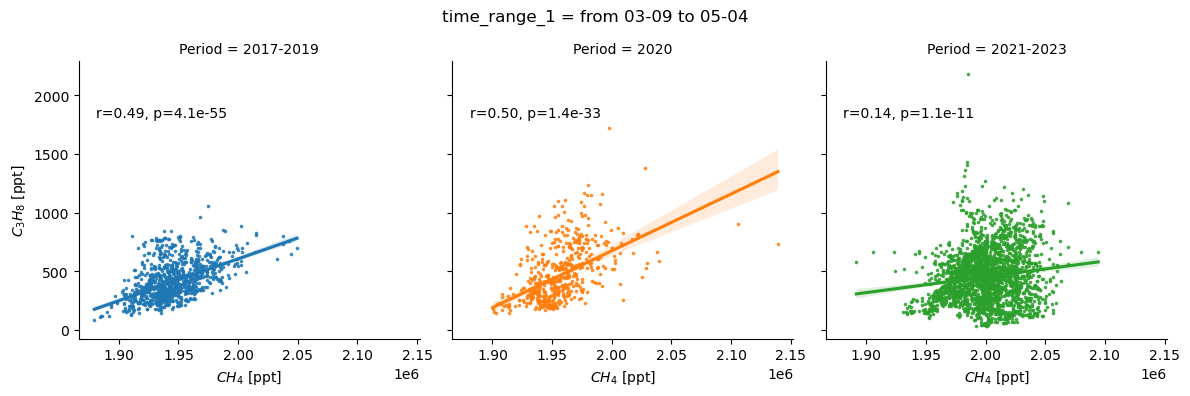

In [41]:
# time range 1
# 3 time ranges (I Lockdown, mild measures, II lockdown) for the  '2011-2019', '2020', '2021', '2022-2023' years


g=sns.lmplot(x='ch4_ppt', y='C3H8', data=range_1_combined, robust=True, hue='Period', markers='.', scatter_kws={"s": 10}, col='Period', height=4)
#plt.title("Scatter Plot with Linear fit")
titles = {221: '2011-2019', 222: '2020', 223: '2022-2023'}

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['ch4_ppt'], data['C3H8'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    #ax.set_title(f'Year: {year}')
    ax.set_xlabel('$CH_4$ [ppt]')
    ax.set_ylabel('$C_3H_8$ [ppt]')
    ax.ticklabel_format(axis='x', style='sci', 
                          scilimits=(0,0))

g.map_dataframe(annotate)
plt.subplots_adjust(top=0.85)
plt.suptitle('time_range_1 = from 03-09 to 05-04')
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CH4_Covid1_ST.png", dpi=300)
plt.show()
        
    





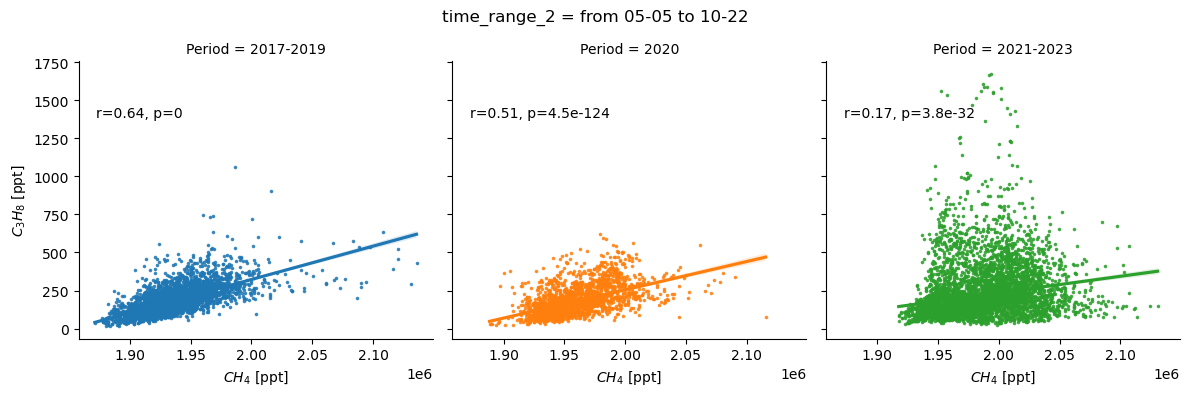

In [ ]:
# time range 2
# 3 time ranges (I Lockdown, mild measures, II lockdown) for the  '2011-2019', '2020', '2021', '2022-2023' years


g=sns.lmplot(x='ch4_ppt', y='C3H8', data=range_2_combined, robust=True, hue='Period', markers='.', scatter_kws={"s": 10}, col='Period', height=4)
#plt.title("Scatter Plot with Linear fit")
titles = {221: '2011-2019', 222: '2020', 223: '2022-2023'}

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['ch4_ppt'], data['C3H8'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    #ax.set_title(f'Year: {year}')
    ax.set_xlabel('$CH_4$ [ppt]')
    ax.set_ylabel('$C_3H_8$ [ppt]')
    ax.ticklabel_format(axis='x', style='sci', 
                          scilimits=(0,0))

g.map_dataframe(annotate)
plt.subplots_adjust(top=0.85)
plt.suptitle('time_range_2 = from 05-05 to 10-22')
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CH4_Covid2_ST.png", dpi=300)
plt.show()
        

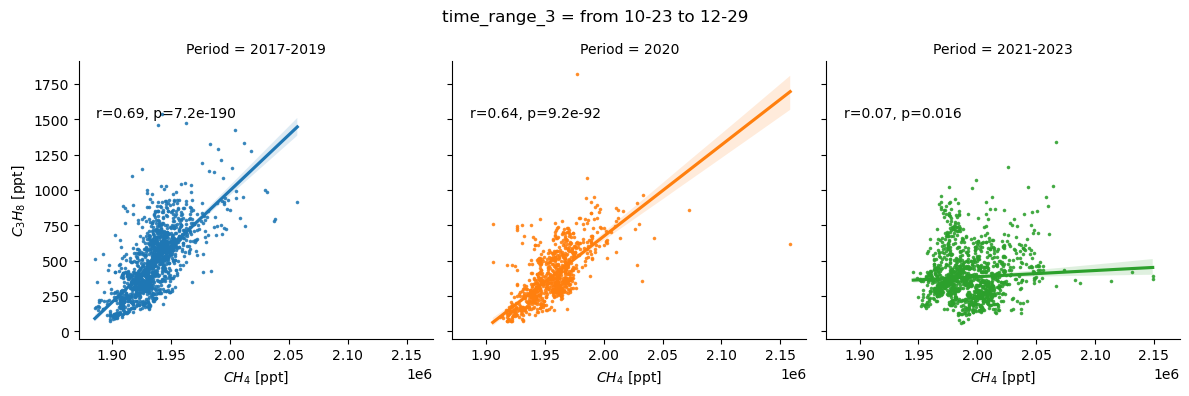

In [ ]:
# # time range 3
# 3 time ranges (I Lockdown, mild measures, II lockdown) for the  '2011-2019', '2020', '2021', '2022-2023' years


g=sns.lmplot(x='ch4_ppt', y='C3H8', data=range_3_combined, robust=True, hue='Period', markers='.', scatter_kws={"s": 10}, col='Period', height=4)
#plt.title("Scatter Plot with Linear fit")
titles = {221: '2011-2019', 222: '2020', 223: '2022-2023'}

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['ch4_ppt'], data['C3H8'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    #ax.set_title(f'Year: {year}')
    ax.set_xlabel('$CH_4$ [ppt]')
    ax.set_ylabel('$C_3H_8$ [ppt]')
    ax.ticklabel_format(axis='x', style='sci', 
                          scilimits=(0,0))

g.map_dataframe(annotate)
plt.subplots_adjust(top=0.85)
plt.suptitle('time_range_3 = from 10-23 to 12-29')
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CH4_Covid3_ST.png", dpi=300)
plt.show()

In [ ]:
#To generate boxplots for the three time periods for the year 2020 and compare them with the time range 2011-2019, 2021-2023
# Extract year, month, and day from 'Date'

# Separate 2020, 2021-2023, 2011-2019 data for each time range
def get_year_split(data):
    data_2020 = data[data['year'] == 2020]
    data_2011_2019 = data[(data['year'] >= 2011) & (data['year'] <= 2019)]
    data_2021_2023 = data[(data['year'] >= 2021) & (data['year'] <= 2023)]
    return data_2020, data_2021_2023, data_2011_2019

range_1_2020, range_1_2021_2023, range_1_2011_2019  = get_year_split(range_1_data)
range_2_2020, range_2_2021_2023, range_2_2011_2019 = get_year_split(range_2_data)
range_3_2020, range_3_2021_2023, range_3_2011_2019 = get_year_split(range_3_data)

In [ ]:
# Add a 'Period' column to distinguish among 2020, 2021, 2022-2023 and 2011-2019
range_1_2011_2019['Period'] = '2011-2019'
range_1_2020['Period'] = '2020'
range_1_2021_2023['Period'] = '2021-2023'
range_2_2011_2019['Period'] = '2011-2019'
range_2_2020['Period'] = '2020'
range_2_2021_2023['Period'] = '2021-2023'
range_3_2011_2019['Period'] = '2011-2019'
range_3_2020['Period'] = '2020'
range_3_2021_2023['Period'] = '2021-2023'


# Combine the data for each time range
range_1_combined = pd.concat([range_1_2011_2019,range_1_2020,range_1_2021_2023])
range_2_combined = pd.concat([range_2_2011_2019,range_2_2020, range_2_2021_2023])
range_3_combined = pd.concat([range_3_2011_2019, range_3_2020,range_3_2021_2023 ])

In [ ]:
#boxplt comparison among 3 time ranges (I Lockdown, mild measures, II lockdown) for the  '2011-2019', '2020', '2021-2023' years

# Define the plotting function
def plot_boxplot_with_mean(ax, data, title):
    sns.boxplot(
        x='Period', y='C3H8', data=data, ax=ax,
        showfliers=False,  # Hide outliers
        whis=[5, 95],      # Whiskers representing 5th–95th percentiles
        showmeans=True, fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'}
    )
    
    # Set the title
    ax.set_title(title, fontsize=14)
    
    # Set x-axis labels
    time_order = ['2011-2019', '2020', '2021-2023']
    ax.set_xticks(range(len(time_order)))
    ax.set_xticklabels(time_order, fontsize=12)
    
    
    ax.set_ylabel('C3H8 [ppt]', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)
    
    # Set y-axis tick size
    ax.tick_params(axis='y', labelsize=12)

    # Set y-axis limits
    ax.set_ylim(0, 1000)

# Calculate and plot the mean values
    means = data.groupby('Period')['C3H8'].mean()
    for i, mean_value in enumerate(means):
        # Add text next to the diamond markers
        ax.text(i, mean_value + 6, f'{mean_value:.1f}', color='black', ha='center', fontsize=12)

# Create the figure
plt.figure(figsize=(14, 8))

# Plot for Time Range 1
ax1 = plt.subplot(1, 3, 1)
plot_boxplot_with_mean(ax1, range_1_combined, 'I lockdown')

# Plot for Time Range 2
ax2 = plt.subplot(1, 3, 2)
plot_boxplot_with_mean(ax2, range_2_combined, 'Mild restrictions')

# Plot for Time Range 3
ax3 = plt.subplot(1, 3, 3)
plot_boxplot_with_mean(ax3, range_3_combined, 'II lockdown')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CMN_COVID_3_timeRanges.png", dpi=300)
plt.show()


In [ ]:
# Define your time ranges
time_range_1 = ('03-09', '05-04')
time_range_2 = ('05-05', '10-22')
time_range_3 = ('10-23', '12-29')

# Function to filter the data by year and time range
def filter_by_time_range(df, year, time_range):
    start_date = pd.to_datetime(f"{year}-{time_range[0]}")
    end_date = pd.to_datetime(f"{year}-{time_range[1]}")
    return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Create lists to hold data for ANOVA
data_range_1, data_range_2, data_range_3 = [], [], []

# Iterate over the time ranges and periods, and collect data
years_groups = [(2011, 2019), (2020, 2020), (2021, 2023)]

for start_year, end_year in years_groups:
    for year in range(start_year, end_year + 1):
        # Collect data for each time period within each year
        data_range_1.append(filter_by_time_range(df, year, time_range_1)['C3H8'].values)
        data_range_2.append(filter_by_time_range(df, year, time_range_2)['C3H8'].values)
        data_range_3.append(filter_by_time_range(df, year, time_range_3)['C3H8'].values)

# Flatten the data (if you have a list of arrays, combine them into one list for each time period)
data_range_1 = [val for sublist in data_range_1 for val in sublist]
data_range_2 = [val for sublist in data_range_2 for val in sublist]
data_range_3 = [val for sublist in data_range_3 for val in sublist]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(data_range_1, data_range_2, data_range_3)

# Print the results
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of p-value
if p_value < 0.05:
    print("The mean values across the time periods are significantly different.")
else:
    print("No significant difference between the means of the time periods.")

In [ ]:
#To generate boxplots for the three time periods for the year 2020 and compare them with the time range 2011-2019, 2021-2023
# Extract year, month, and day from 'Date'



# Separate 2020, 2021-2023, 2011-2019 data for each time range
def get_year_split(data):
    data_2020 = data[data['year'] == 2020]
    data_2011_2019 = data[(data['year'] >= 2011) & (data['year'] <= 2019)]
    data_2021_2023 = data[(data['year'] >= 2021) & (data['year'] <= 2023)]
    return data_2020, data_2021_2023, data_2011_2019

range_2020, range_2021_2023, range_2011_2019  = get_year_split(df)


In [ ]:
#boxplt comparison among 3 time ranges:  '2011-2019', '2020', '2021-2023' years
# Define time periods: 2011-2019, 2020, 2021-2023
def assign_period(date):
    if pd.Timestamp('2011-01-01') <= date <= pd.Timestamp('2019-12-31'):
        return '2011-2019'
    elif pd.Timestamp('2020-01-01') <= date <= pd.Timestamp('2020-12-31'):
        return '2020'
    elif pd.Timestamp('2021-01-01') <= date <= pd.Timestamp('2023-12-31'):
        return '2021-2023'
    else:
        return None

# Apply this to your dataframe to create a 'Period' column
df['Period'] = pd.to_datetime(df['date']).apply(assign_period)

# Function to plot the boxplot and display the mean values
def plot_boxplot_with_mean(data, ax):
    sns.boxplot(
        x='Period', y='C3H8', data=data, ax=ax,
        showfliers=False,  # Hide outliers
        whis=[5, 95],      # Whiskers representing 5th–95th percentiles
        showmeans=True,
        fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'}
    )

    # Calculate the mean values for each period
    means = data.groupby('Period')['C3H8'].mean()

    # Add the mean values above the diamond markers
    for i, (period, mean_value) in enumerate(means.items()):
        ax.text(i, mean_value + 5, f'{mean_value:.2f}', color='black', ha='center', fontsize=10)

    # Set labels and limits
    ax.set_ylabel('$C_3H_8$ [ppt]', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylim(0,  1000)  # Adjust y-axis limit based on the data range
    ax.tick_params(axis='y', labelsize=12)
    #ax.set_title('C3H8 Levels by Time Range', fontsize=16)

# Create the figure for the boxplot
plt.figure(figsize=(8, 6))

# Create a single subplot for the three periods
ax = plt.subplot(1, 1, 1)
plot_boxplot_with_mean(df, ax)

# Adjust layout
plt.tight_layout()


# Show the plot
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CMN_COVID_yearRanges.png", dpi=300)
#plt.show()


In [ ]:
median = df.groupby('Period')['C3H8'].quantile(0.5)
median